In [1]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import re
from gensim.models.coherencemodel import CoherenceModel
import gensim
import gensim.corpora as corpora
from pprint import pprint

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Load dataset
df = pd.read_csv(r'dataset.csv')
print("Dataset shape:", df.shape)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset shape: (4589, 9)


,Unnamed: 0,links,symbol,company,Title,Text,Publishdate,Industry,Sentiment
0,3038,https://www.cnbc.com/2024/01/04/jim-cramer-rev...,NDAQ,"Nasdaq, Inc.",Jim Cramer reviews the worst performers on the...,CNBC's Jim Cramer on Thursday gave his take on...,4-Jan-24,Financial Services,0.0
1,1080,https://www.cnbc.com/2024/01/04/top-stocks-to-...,CMA,Comerica,Here are Thursday's biggest analyst calls: Nvi...,Here are the biggest calls on Wall Street on T...,4-Jan-24,Financial Services,0.0
2,222,https://www.cnbc.com/select/amex-centurion-new...,AXP,American Express,American Express is opening an exclusive club ...,Subscribe to the Select Newsletter! Our best s...,19-Jan-23,Financial Services,0.0
3,223,https://www.cnbc.com/select/american-express-c...,AXP,American Express,American Express Cardholders Get Free Drinks a...,The offer mentioned below is no longer availab...,12-Oct-22,Financial Services,0.0
4,224,https://www.cnbc.com/select/american-express-p...,AXP,American Express,American Express is partnering with TikTok to ...,Terms apply to American Express benefits and o...,14-Nov-22,Financial Services,0.0


### 1. Verb Phrases Extraction 

1. Added custom verb phrase extraction
2. Included analysis of verb phrase structure
3. Added prepositional phrase extraction
4. Processes the 'text' column instead of 'title'

In [14]:
def extract_phrases(text)   :     
    """
    Extract noun phrases, verb phrases, and other relevant phrases from text.
    """
    doc = nlp(text) # spacy module initialized earlier
    
    phrases = {
        'noun_phrases': [],
        'verb_phrases': [],
    }
    
    # Extract noun phrases
    phrases['noun_phrases'] = [chunk.text for chunk in doc.noun_chunks]
    
    # Extract verb phrases
    for token in doc:
        if token.pos_ == "VERB":
            # Get the verb and its children
            verb_phrase = []
            verb_phrase.append(token.text)
            
            # Add auxiliary verbs
            for child in token.children:
                if child.dep_ in ['aux', 'auxpass']: # auxiliary and passive auxiliary
                    verb_phrase.append(child.text)
                    
            # Add direct objects
            for child in token.children:
                if child.dep_ == 'dobj': # the noun that receives the action of the verb
                    verb_phrase.append(child.text)
            
            phrases['verb_phrases'].append(' '.join(sorted(verb_phrase)))
    
    return phrases

Extract verb phrases first, later I will conduct analysis on them

In [15]:
# Phrases extraction

sample_text = df['Text'].iloc[0] # take the first row
phrases = extract_phrases(sample_text)
print("Sample text:", sample_text)
print("\nExtracted phrases:")
pprint(phrases)

Sample text: CNBC's Jim Cramer on Thursday gave his take on the worst performers in the Nasdaq-100 in 2023.

Cramer compared each company's closing price in 2022 to the end of 2023, noting the biggest losers. The list included healthcare companies as well as several utilities outfits.

"You've heard of the Dogs of the Dow? Well, now I want to talk to you about the Gnats of the Nasdaq, the worst performers in the Nasdaq-100 for 2023," Cramer said. "Just like the dogs of the Dow, maybe, just maybe, there are some quality stocks here that are ready to make a comeback."

Extracted phrases:
{'noun_phrases': ["CNBC's Jim Cramer",
                  'Thursday',
                  'his take',
                  'the worst performers',
                  'the Nasdaq-100',
                  'Cramer',
                  "each company's closing price",
                  'the end',
                  'the biggest losers',
                  'The list',
                  'healthcare companies',
           

What constitues a verb phrase?
- A verb phrase consists of a verb plus another word that further illustrates the verb tense, action, and tone
- Verb and its children
    - Subject-related:
        - nsubj: Nominal subject ("John" in "John runs")
    - Object-related:
        - iobj: Indirect object ("Mary" in "give Mary the book")
    - Modifiers
        - tmod: Temporal modifier ("yesterday" in "left yesterday")

In [12]:
def analyze_verb_phrase_structure(text):
    """Analyze the structure of verb phrases in the text."""
    doc = nlp(text)
    verb_structures = []
    
    for token in doc:
        if token.pos_ == "VERB":
            structure = {
                'main_verb': token.text,
                'aux_verbs': [],
                'objects': [],
                'adverbs': []
            }
            
            for child in token.children:
                if child.dep_ in ['aux', 'auxpass']:
                    structure['aux_verbs'].append(child.text)
                elif child.dep_ in ['dobj', 'pobj']:
                    structure['objects'].append(child.text)
                elif child.pos_ == 'ADV':
                    structure['adverbs'].append(child.text)
            
            verb_structures.append(structure)
    
    return verb_structures

In [16]:
# Analyze sample text
sample_structures = analyze_verb_phrase_structure(sample_text)
print("Sample text:", sample_text)
print("Verb phrase structures:")
pprint(sample_structures)

Sample text: CNBC's Jim Cramer on Thursday gave his take on the worst performers in the Nasdaq-100 in 2023.

Cramer compared each company's closing price in 2022 to the end of 2023, noting the biggest losers. The list included healthcare companies as well as several utilities outfits.

"You've heard of the Dogs of the Dow? Well, now I want to talk to you about the Gnats of the Nasdaq, the worst performers in the Nasdaq-100 for 2023," Cramer said. "Just like the dogs of the Dow, maybe, just maybe, there are some quality stocks here that are ready to make a comeback."
Verb phrase structures:
[{'adverbs': [], 'aux_verbs': [], 'main_verb': 'gave', 'objects': ['take']},
 {'adverbs': [],
  'aux_verbs': [],
  'main_verb': 'compared',
  'objects': ['price']},
 {'adverbs': [], 'aux_verbs': [], 'main_verb': 'noting', 'objects': ['losers']},
 {'adverbs': [],
  'aux_verbs': [],
  'main_verb': 'included',
  'objects': ['companies']},
 {'adverbs': [], 'aux_verbs': [], 'main_verb': 'outfits', 'object

### 2. Topic Modeling Weight Analysis

##### Let's address the issue with topic weights and normalize them for better interpretation.

In [54]:
def normalize_and_visualize_topic_weights(lda, vectorizer):
    """
    Normalize topic weights and extract top words per topic.
    Returns topic weights and top words DataFrames.
    """
    feature_names = vectorizer.get_feature_names_out()
    topic_term_matrix = lda.components_
    
    # Normalize weights
    normalized_weights = topic_term_matrix / topic_term_matrix.sum(axis=1)[:, np.newaxis]
    
    # Create DataFrame of weights
    topic_weights = pd.DataFrame(
        normalized_weights.T,
        index=feature_names,
        columns=[f"Topic #{i}" for i in range(normalized_weights.shape[0])]
    )
    
    # Get top words for each topic
    top_words = pd.DataFrame()
    for topic_idx, topic in enumerate(normalized_weights):
        # Get indices of words with highest weights
        top_indices = (-topic).argsort()[:10]  # Changed this line
        # Get the words and store them
        top_words[f"Topic #{topic_idx}"] = [feature_names[i] for i in top_indices]
    
    return topic_weights, top_words

def plot_topic_weights(topic_weights, top_words, num_topics=5, num_words=3):
    """
    Plot topic-word distributions as bubble plot.
    Bubble size represents word importance in topic.
    """
    plt.figure(figsize=(15, 8))
    
    # Create bubble plot
    for topic_idx in range(num_topics):
        topic_name = f"Topic #{topic_idx}"
        words = list(top_words[topic_name])[:num_words]
        weights = [topic_weights.loc[word, topic_name] for word in words]
        
        # Plot each word as a bubble
        for i, (word, weight) in enumerate(zip(words, weights)):
            # Create bubble - size corresponds to weight
            bubble = plt.scatter(topic_idx, i, 
                               s=weight*5000,  # Adjust multiplier for better visibility
                               alpha=0.6,
                               label=f"Topic {topic_idx}" if i == 0 else "")
            
            # Add word label in center of bubble
            plt.annotate(word, 
                        (topic_idx, i),
                        ha='center', va='center',  # Center the text
                        fontsize=10)
    
    plt.title("Topic Words Distribution")
    plt.xlabel("Topics")
    plt.ylabel("Top Words")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.ylim(-0.5, num_words-0.5)  # Adjust y-axis limits
    plt.xlim(-0.5, num_topics-0.5)  # Adjust x-axis limits
    
    plt.tight_layout()
    plt.show()

In [29]:
print("Number of NaN values:", df['Text'].isna().sum())
# Option 1: Remove rows with NaN values
df = df.dropna(subset=['Text'])
print("Number of NaN values:", df['Text'].isna().sum())

Number of NaN values: 8
Number of NaN values: 0


In [55]:
# Apply to our LDA model
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2) # ignore top 90% freq words, words appear in less than 2 docs
X = vectorizer.fit_transform(df['Text'])
lda = LatentDirichletAllocation(n_components=10, random_state=42, max_iter=50)
lda.fit(X)

LatentDirichletAllocation(max_iter=50, random_state=42)

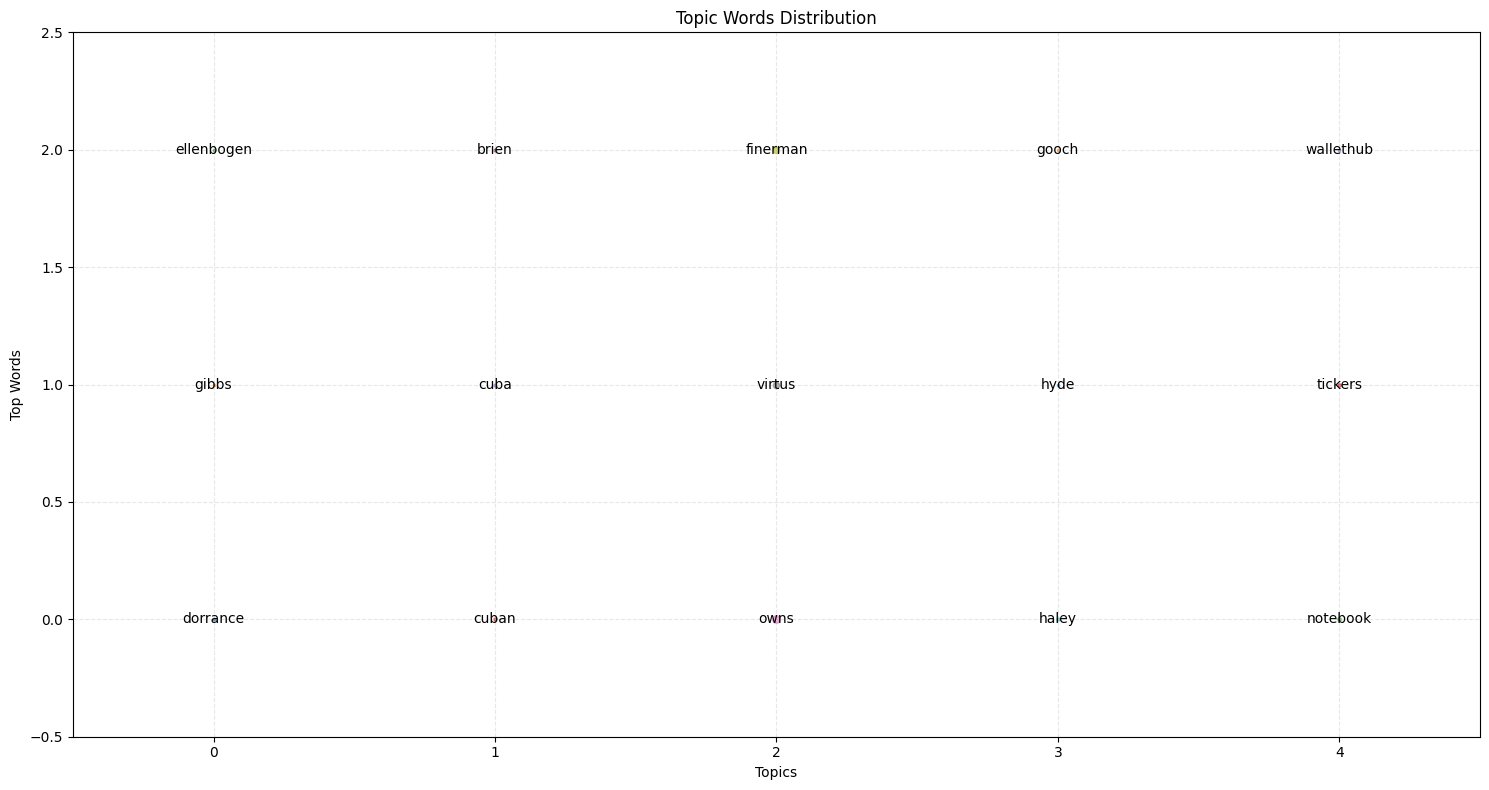

In [56]:
# Generate and plot topic weights
topic_weights, top_words = normalize_and_visualize_topic_weights(lda, vectorizer)
plot_topic_weights(topic_weights, top_words, num_topics=5, num_words=3)

### 4. Perplexity Score Analysis 
##### Perplexity is a measure of how well a probability model predicts a sample. Lower perplexity indicates better generalization.

##### Perplexity = exp(-1 * (log-likelihood) / number_of_words)

Explaination:
- Log-likelihood is the sum of log probabilities for each word in a sequence
- Normalizes the score for sequences of different lengths (average log-likelihood per word)
- exp converts from log probability space back to probability space
- Perplexity of 100 -> It has to choose between 100 equally likely words at each step

##### Intuition:
- Lower perplexity = better model
- Typical range: 10-100 for well-fitted models 
- Values over 1000 might indicate poor fit

Topics: 2, Perplexity: 1843.91
Topics: 4, Perplexity: 2331.59
Topics: 6, Perplexity: 2590.19
Topics: 8, Perplexity: 2815.12
Topics: 10, Perplexity: 2970.02
Topics: 12, Perplexity: 3209.83
Topics: 14, Perplexity: 3292.43


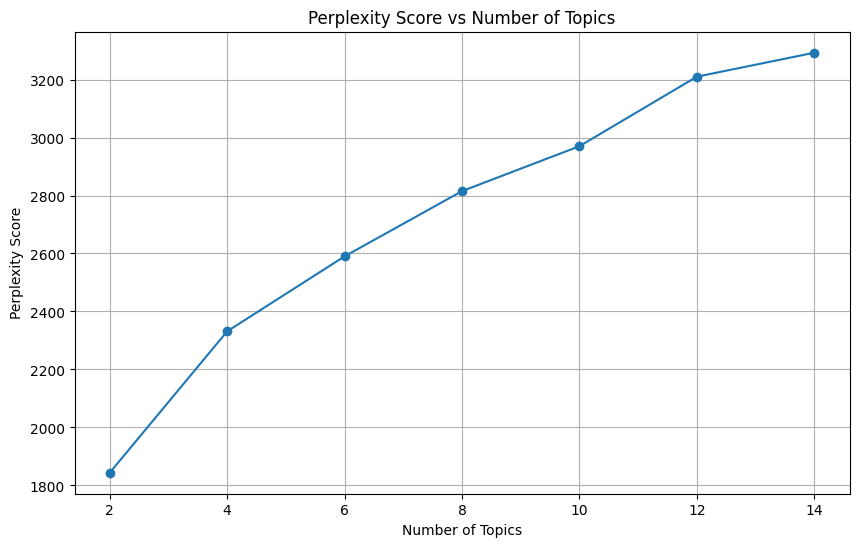

In [70]:
def analyze_perplexity(X, n_topics_range):
    """
    Analyze perplexity scores across different numbers of topics.
    """
    perplexities = []
    
    for n_topics in n_topics_range:
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X)
        perplexity = lda.perplexity(X)
        perplexities.append(perplexity)
        print(f"Topics: {n_topics}, Perplexity: {perplexity:.2f}")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.plot(n_topics_range, perplexities, marker='o')
    plt.title('Perplexity Score vs Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity Score')
    plt.grid(True)
    plt.show()

# Analyze perplexity for different numbers of topics
n_topics_range = range(2, 15, 2)
analyze_perplexity(X, n_topics_range) # X is the vectorized features 

In [58]:
# Check data before running LDA
print("Document lengths:")
print(X.sum(axis=1).mean(), "average words per document")
print(X.sum(axis=1).min(), "minimum words")
print(X.sum(axis=1).max(), "maximum words")

Document lengths:
11.639655007868186 average words per document
2.3607786025118704 minimum words
28.957096672717427 maximum words


In [62]:
# Maybe need to filter very short documents
min_words = 15  # adjust as needed
doc_lengths = X.sum(axis=1).A1  # dense array of document lengths
mask = doc_lengths >= min_words
X = X[mask]

# Check data before running LDA
print("Document lengths:")
print(X.sum(axis=1).mean(), "average words per document")
print(X.sum(axis=1).min(), "minimum words")
print(X.sum(axis=1).max(), "maximum words")

Document lengths:
17.517629892763683 average words per document
15.001230449488235 minimum words
28.957096672717427 maximum words


Topics: 2, Perplexity: 17456.38
Topics: 4, Perplexity: 21169.94
Topics: 6, Perplexity: 25465.56
Topics: 8, Perplexity: 30584.09
Topics: 10, Perplexity: 36910.10
Topics: 12, Perplexity: 46595.45
Topics: 14, Perplexity: 73042.98


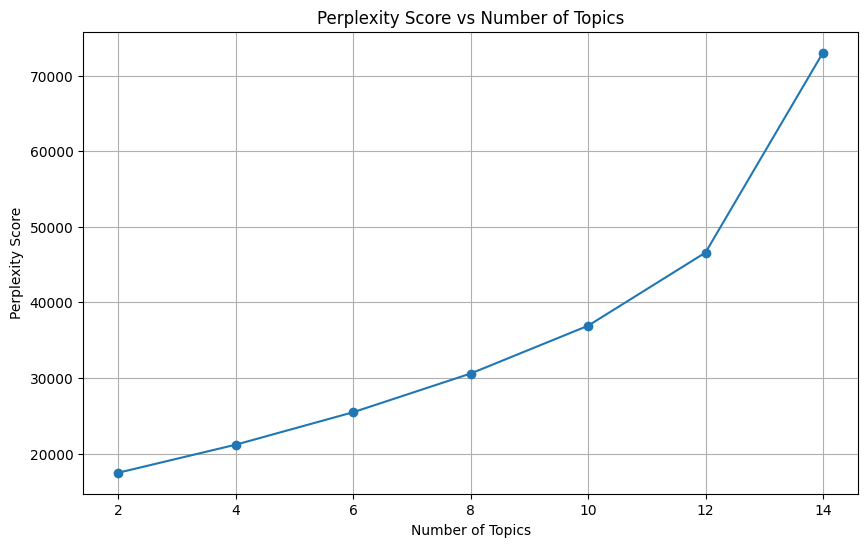

In [63]:
analyze_perplexity(X, n_topics_range) # X is the vectorized features 

Since the result is not desired, let's redo from the beginning

C:\Users\User\AppData\Local\Temp\ipykernel_17984\3309160333.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['Text'].apply(preprocess_text)


Sparsity of document-term matrix: 93.13%
Vocabulary size: 2000
Topics: 2, Perplexity: 1761.16
Topics: 4, Perplexity: 2213.68
Topics: 6, Perplexity: 2543.36
Topics: 8, Perplexity: 2783.62
Topics: 10, Perplexity: 2956.11
Topics: 12, Perplexity: 3212.16
Topics: 14, Perplexity: 3422.34
Topics: 16, Perplexity: 3567.02
Topics: 18, Perplexity: 3313.24
Topics: 20, Perplexity: 3645.78


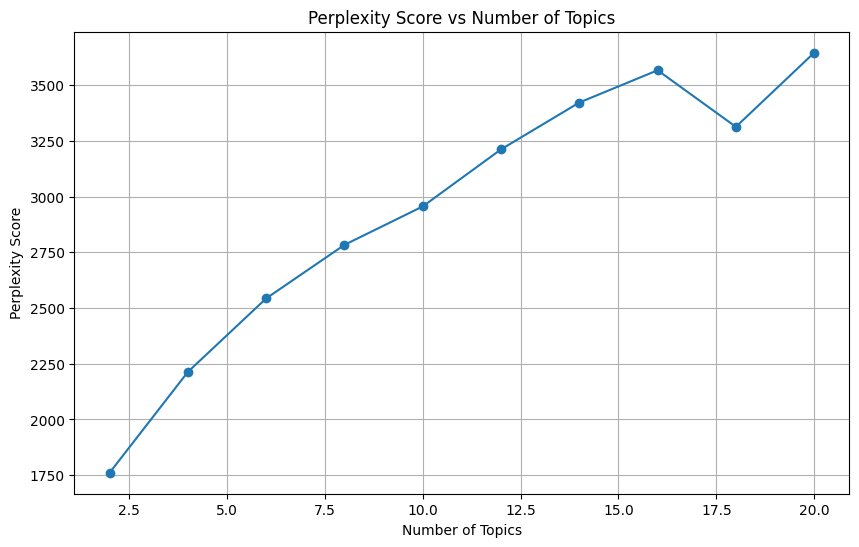

In [72]:
import re

def preprocess_text(text, stem=True):
    """
    Preprocess text by lowercasing, removing special characters,
    and applying stemming/lemmatization.
    
    Args:
        text (str): Input text to preprocess
        stem (bool): If True, use stemming; if False, use lemmatization
        
    Returns:
        str: Preprocessed text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Initialize stemmers/lemmatizers
    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    
    # Apply stemming or lemmatization
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    else:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    text = ' '.join(tokens)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Do some preprocessing
df['text'] = df['Text'].apply(preprocess_text)

# tune parameters according to some forums/literatures
vectorizer = TfidfVectorizer(
    max_df=0.7,        # Remove words that appear in >70% of docs
    min_df=5,          # Remove words that appear in <5 docs
    stop_words='english',
    max_features=2000, # Limit vocabulary to top 2000 words (quite random)
    ngram_range=(1,1)  # Only use single words (no phrases)
)       

# Create document-term matrix
X = vectorizer.fit_transform(df['text'])

# The scenario where a large percentage of data within a dataset is missing or is set to zero
sparsity = 1.0 - (X.nnz / float(X.shape[0] * X.shape[1]))
print(f"Sparsity of document-term matrix: {sparsity:.2%}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

# Now run LDA with these changes
n_topics_range = range(2, 21, 2)
analyze_perplexity(X, n_topics_range)

Do once again with lower max featurs (unique words) -> decrease the sparsity 

Sparsity of document-term matrix: 83.57%
Vocabulary size: 500
Topics: 2, Perplexity: 500.90
Topics: 4, Perplexity: 609.70
Topics: 6, Perplexity: 700.69
Topics: 8, Perplexity: 762.46
Topics: 10, Perplexity: 827.23
Topics: 12, Perplexity: 860.57
Topics: 14, Perplexity: 929.40
Topics: 16, Perplexity: 941.49
Topics: 18, Perplexity: 977.79
Topics: 20, Perplexity: 1004.00


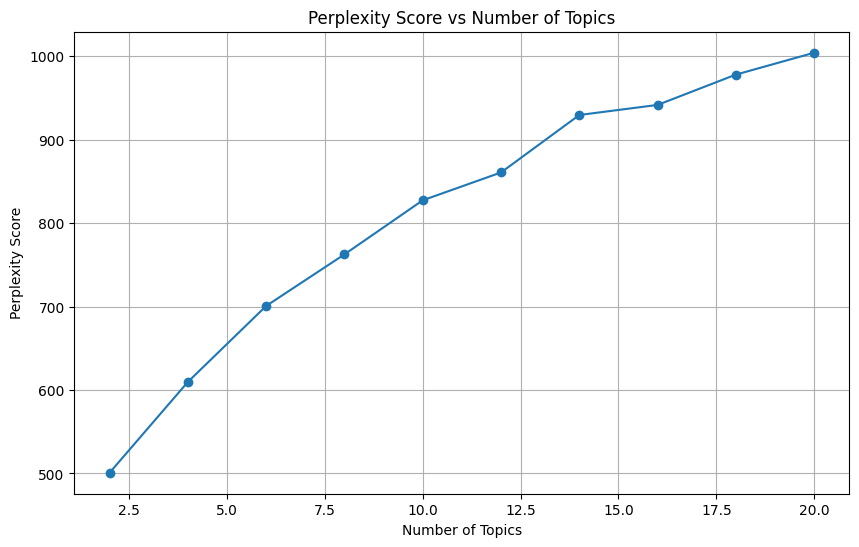

In [74]:
# tune parameters according to some forums/literatures
vectorizer = TfidfVectorizer(
    max_df=0.7,        # Remove words that appear in >70% of docs
    min_df=5,          # Remove words that appear in <5 docs
    stop_words='english',
    max_features=500, # Limit vocabulary to top 2000 words (quite random)
    ngram_range=(1,1)  # Only use single words (no phrases)
)       

# Create document-term matrix
X = vectorizer.fit_transform(df['text'])

# The scenario where a large percentage of data within a dataset is missing or is set to zero
sparsity = 1.0 - (X.nnz / float(X.shape[0] * X.shape[1]))
print(f"Sparsity of document-term matrix: {sparsity:.2%}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

# Now run LDA with these changes
n_topics_range = range(2, 21, 2)
analyze_perplexity(X, n_topics_range)

### 5. Coherence Score Analysis

#### Coherence score measures how semantically similar the words within each topic are.
##### Formula:
C_v = mean(similarity(word pairs within topic))
##### Intuition:
Higher coherence = more interpretable topics
Typical range: 0.4-0.6 is considered good
#Values above 0.7 are excellent

In [75]:
def compute_coherence_scores(texts, dictionary, n_topics_range):
   """
   Compute coherence scores for different numbers of topics with preprocessing and error handling.
   """
   # Create corpus with frequency filtering
   word_freq = Counter([word for text in texts for word in text])
   texts = [[word for word in text if word_freq[word] >= 5] for text in texts]
   texts = [text for text in texts if len(text) > 0]
   corpus = [dictionary.doc2bow(text) for text in texts]
   
   coherence_scores = []
   for n_topics in n_topics_range:
       try:
           # Create and train LDA model
           lda_model = gensim.models.LdaModel(
               corpus=corpus,
               num_topics=n_topics,
               id2word=dictionary,
               passes=10,
               iterations=400,
               random_state=42
           )
           
           # Compute coherence score
           coherence_model = CoherenceModel(
               model=lda_model,
               texts=texts,
               dictionary=dictionary,
               coherence='c_v'
           )
           score = coherence_model.get_coherence()
           coherence_scores.append(score)
           print(f"Topics: {n_topics}, Coherence Score: {score:.4f}")
           
       except Exception as e:
           print(f'Error computing coherence for {n_topics} topics: {str(e)}')
           coherence_scores.append(None)
   
   return coherence_scores

# Usage:
df['tokens'] = df['Text'].apply(lambda x: preprocess_text(x, stem=True))
dictionary = corpora.Dictionary(df['tokens'])
coherence_scores = compute_coherence_scores(df['tokens'], dictionary, range(2, 21, 2))

In [81]:
def tokenize(text, stem=True):
    """
    Preprocess text by lowercasing, removing special characters,
    and applying stemming/lemmatization.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Initialize stemmers/lemmatizers
    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    
    # Apply stemming or lemmatization
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    else:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [82]:
df['tokens'] = df['Text'].apply(tokenize)  # Store as tokens
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Compute and visualize coherence scores
n_topics_range = range(2, 21, 2)
coherence_scores = compute_coherence_scores(df['text'], dictionary, n_topics_range)

c:\Users\User\miniconda3\envs\ds\Lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
c:\Users\User\miniconda3\envs\ds\Lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Topics: 2, Coherence Score: nan


KeyboardInterrupt: 